<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Libraries" data-toc-modified-id="Libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Libraries</a></span></li><li><span><a href="#Setup" data-toc-modified-id="Setup-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Setup</a></span></li><li><span><a href="#Data-Preparation" data-toc-modified-id="Data-Preparation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data Preparation</a></span></li><li><span><a href="#Analysis" data-toc-modified-id="Analysis-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Analysis</a></span></li></ul></div>

## Libraries

In [131]:
import logging
import sys

import math
import numpy as np
import pandas as pd
from pandas_gbq import read_gbq

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Setup

In [20]:
logger = logging.getLogger('pandas_gbq')
logger.setLevel(logging.INFO)
logger.addHandler(logging.StreamHandler(stream=sys.stdout))

In [7]:
PROJECT_ID = 'ad-fantasy-football'
SERVICE_ACCOUNT_PATH = '../credentials/bigquery-loader.json'

In [8]:
PARAMS = {
    'participants': '12'
}

In [68]:
SQL_BASE = \
"""
SELECT
  CONCAT(CAST(qb_count AS STRING), '-', CAST(rb_count AS STRING), '-', CAST(wr_count AS STRING), '-', CAST(te_count AS STRING)) AS position_counts,
  (CASE WHEN league_rank = 1 THEN 1 ELSE 0 END) AS win_flag,
  *
FROM
  (
    SELECT
      draft_id,
      team_id,
      COUNT(DISTINCT (CASE WHEN position = 'QB' THEN player_id END)) AS qb_count,
      COUNT(DISTINCT (CASE WHEN position = 'RB' THEN player_id END)) AS rb_count,
      COUNT(DISTINCT (CASE WHEN position = 'WR' THEN player_id END)) AS wr_count,
      COUNT(DISTINCT (CASE WHEN position = 'TE' THEN player_id END)) AS te_count,
      COALESCE(SUM(CASE WHEN position = 'QB' AND player_counts THEN live_projected_points END), 0) AS qb_points,
      COALESCE(SUM(CASE WHEN position = 'RB' AND player_counts THEN live_projected_points END), 0) AS rb_points,
      COALESCE(SUM(CASE WHEN position = 'WR' AND player_counts THEN live_projected_points END), 0) AS wr_points,
      COALESCE(SUM(CASE WHEN position = 'TE' AND player_counts THEN live_projected_points END), 0) AS te_points,
      MIN(league_rank) AS league_rank,
      MAX(total_points) AS total_points
    FROM
      `ad-fantasy-football.playdraft.v_full`
    WHERE
      participants = {participants}
    GROUP BY 1, 2
  )
"""

In [69]:
sql_base = SQL_BASE.format(**PARAMS)

df_base = pd.read_gbq(query=sql_base, project_id=PROJECT_ID, dialect='standard',
                      private_key=SERVICE_ACCOUNT_PATH)

Requesting query... 
Requesting query... 
ok.
Query running...
ok.
Query running...
Job ID: 1587b984-3cbe-4f1c-b9f3-66fa7daa1175
Query running...
Job ID: 1587b984-3cbe-4f1c-b9f3-66fa7daa1175
Query running...
  Elapsed 8.04 s. Waiting...
  Elapsed 8.04 s. Waiting...
  Elapsed 9.45 s. Waiting...
  Elapsed 9.45 s. Waiting...
  Elapsed 10.79 s. Waiting...
  Elapsed 10.79 s. Waiting...
  Elapsed 12.21 s. Waiting...
  Elapsed 12.21 s. Waiting...
  Elapsed 13.58 s. Waiting...
  Elapsed 13.58 s. Waiting...
  Elapsed 14.98 s. Waiting...
  Elapsed 14.98 s. Waiting...
Got 36252 rows.

Got 36252 rows.

Total time taken 142.95 s.
Finished at 2018-06-10 12:09:48.
Total time taken 142.95 s.
Finished at 2018-06-10 12:09:48.


In [70]:
df_base.head()

,position_counts,win_flag,draft_id,team_id,qb_count,rb_count,wr_count,te_count,qb_points,rb_points,wr_points,te_points,league_rank,total_points
0,1-5-9-3,1,49f141ed-f8cf-419a-ac7e-c1b61a8d157d,64099b9b-db4b-4ee6-8c83-adc91e6368c9,1,5,9,3,274.74,512.4,651.60,224.7,1,1663.44
1,1-6-9-2,1,094c4a37-65fa-4da1-923c-56ae7cdd0ed2,06fdc3bc-3ed2-4cfd-b779-17b45c3dbc0e,1,6,9,2,338.48,612.1,737.24,181.9,1,1869.72
2,1-6-9-2,1,c3bec6e7-3aad-4429-92bd-82f5b5210906,c07dc75d-5e5c-441a-97d9-abc6d9eeb88a,1,6,9,2,280.10,626.4,684.00,124.5,1,1715.00
3,1-6-9-2,1,a57151a2-1a56-4a38-a0a5-abe22c370e6d,17c85674-ae56-4aff-8e84-817e35b96605,1,6,9,2,257.46,574.7,723.00,150.6,1,1705.76
4,1-6-9-2,1,6323decc-3912-447e-954b-1c4ad7d9fd8b,65659cf1-e371-4b9b-8f7b-58211838545c,1,6,9,2,280.10,460.5,805.94,222.0,1,1768.54


## Data Preparation

In [160]:
POINTS_INTERVAL = 10
POSITIONS = ['qb', 'rb', 'wr', 'te']

In [161]:
df_base['total_points_group'] = np.floor(df_base['total_points'] \
                                         / POINTS_INTERVAL) * POINTS_INTERVAL
df_base['qb_points_group'] = np.floor(df_base['qb_points'] \
                                         / POINTS_INTERVAL) * POINTS_INTERVAL
df_base['rb_points_group'] = np.floor(df_base['rb_points'] \
                                         / POINTS_INTERVAL) * POINTS_INTERVAL
df_base['wr_points_group'] = np.floor(df_base['wr_points'] \
                                         / POINTS_INTERVAL) * POINTS_INTERVAL
df_base['te_points_group'] = np.floor(df_base['te_points'] \
                                         / POINTS_INTERVAL) * POINTS_INTERVAL

In [162]:
df_positions = df_base.groupby([
        'position_counts',
        'qb_count',
        'rb_count',
        'wr_count',
        'te_count'
    ], as_index=False).agg({
        'draft_id': 'count',
        'win_flag': 'sum'
    }).rename(columns={
        'draft_id': 'teams',
        'win_flag': 'wins'
    }).sort_values(by='teams', ascending=False)

df_positions['win_rate'] = df_positions['wins'] / df_positions['teams']

In [163]:
df_points = df_base.groupby([
        'total_points_group'
    ], as_index=False).agg({
        'draft_id': 'count',
        'win_flag': 'sum'
    }).rename(columns={
        'draft_id': 'teams',
        'win_flag': 'wins'
    }).sort_values(by='total_points_group', ascending=False)

df_points['win_rate'] = df_points['wins'] / df_points['teams']

In [116]:
def print_win_rates(df, column, threshold):
    print('Win rates for {:s} with threshold of {:d}'.format(column, threshold))
    
    for value in df[column].unique():
        _df = df[df[column] == value]

        _wins = _df['wins'].sum()
        _teams = _df['teams'].sum()

        if _teams >= threshold:
            print('Win rate for {:s} = {:s}: {: >5} / {: >5}, {:.2%}'
                  .format(column, str(value), _wins, _teams, _wins / _teams))
            
    print('\n')

## Analysis

In [125]:
print_win_rates(df_positions, 'qb_count', 100)
print_win_rates(df_positions, 'rb_count', 100)
print_win_rates(df_positions, 'wr_count', 100)
print_win_rates(df_positions, 'te_count', 100)
print_win_rates(df_positions, 'position_counts', 100)

Win rates for qb_count with threshold of 100
Win rate for qb_count = 2:  1530 / 18526, 8.26%
Win rate for qb_count = 3:  1421 / 16276, 8.73%
Win rate for qb_count = 4:    57 /   819, 6.96%
Win rate for qb_count = 1:    10 /   561, 1.78%


Win rates for rb_count with threshold of 100
Win rate for rb_count = 6:  1551 / 17606, 8.81%
Win rate for rb_count = 5:   799 /  9168, 8.72%
Win rate for rb_count = 7:   541 /  7057, 7.67%
Win rate for rb_count = 8:    39 /   941, 4.14%
Win rate for rb_count = 4:    84 /  1213, 6.92%
Win rate for rb_count = 9:     3 /   111, 2.70%
Win rate for rb_count = 3:     4 /   118, 3.39%


Win rates for wr_count with threshold of 100
Win rate for wr_count = 7:  1485 / 17297, 8.59%
Win rate for wr_count = 6:   662 /  8417, 7.87%
Win rate for wr_count = 8:   703 /  7745, 9.08%
Win rate for wr_count = 9:   117 /  1624, 7.20%
Win rate for wr_count = 5:    39 /   799, 4.88%
Win rate for wr_count = 10:    12 /   253, 4.74%


Win rates for te_count with threshold of 1

In [202]:
sns.set(rc={'figure.figsize':(16,9)})

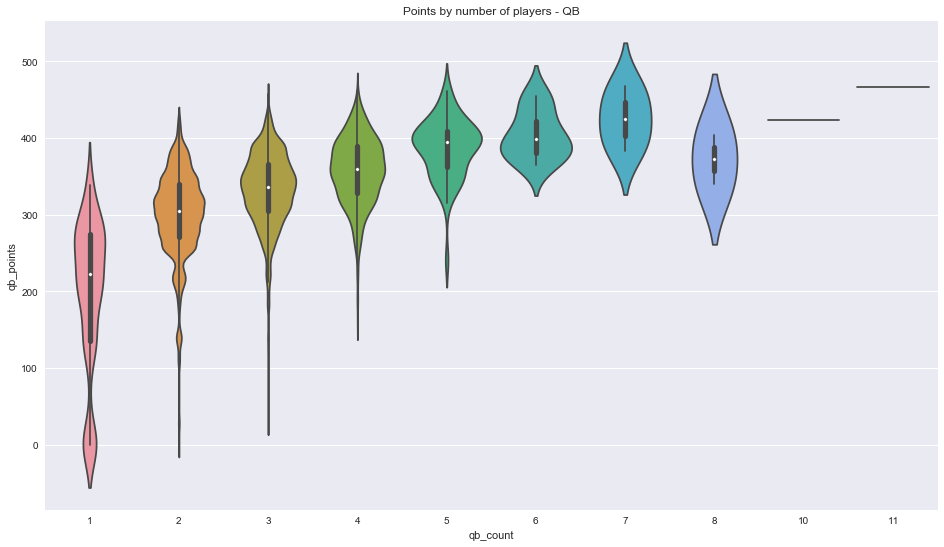

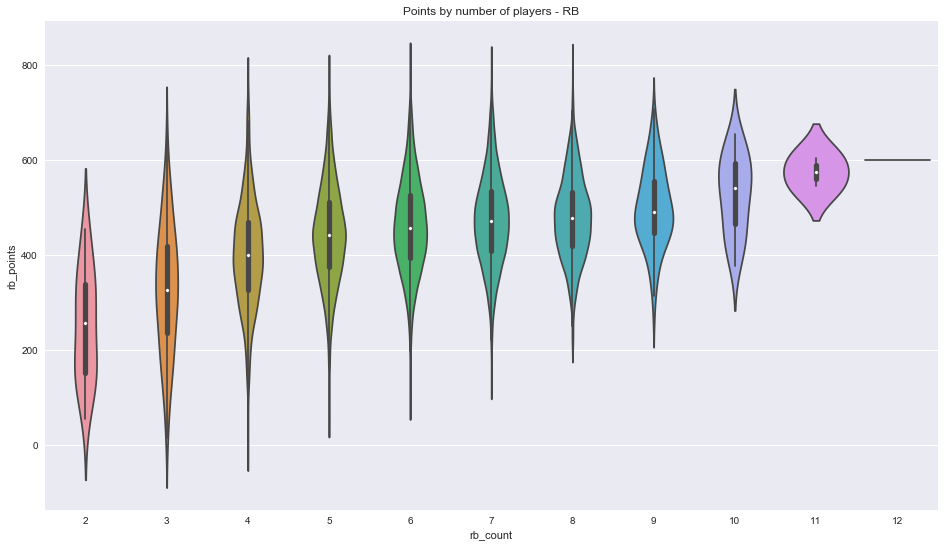

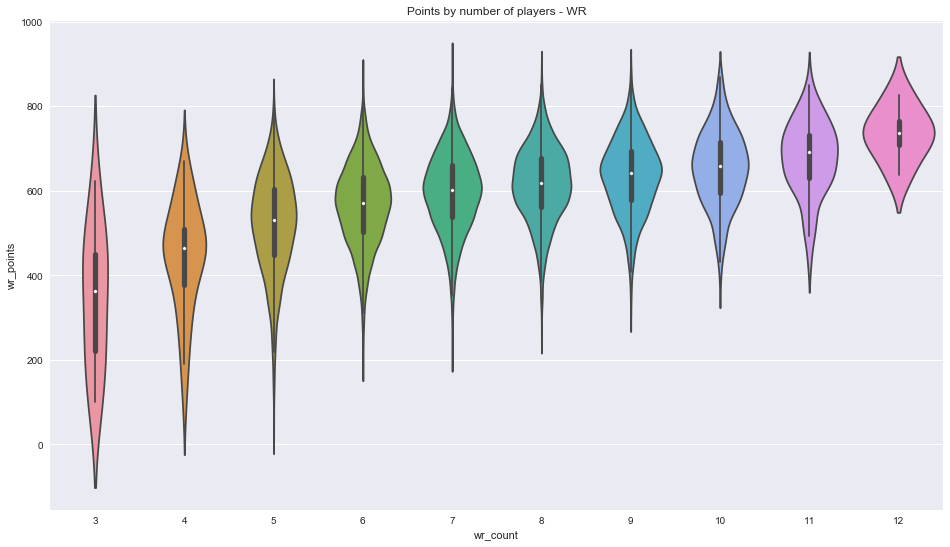

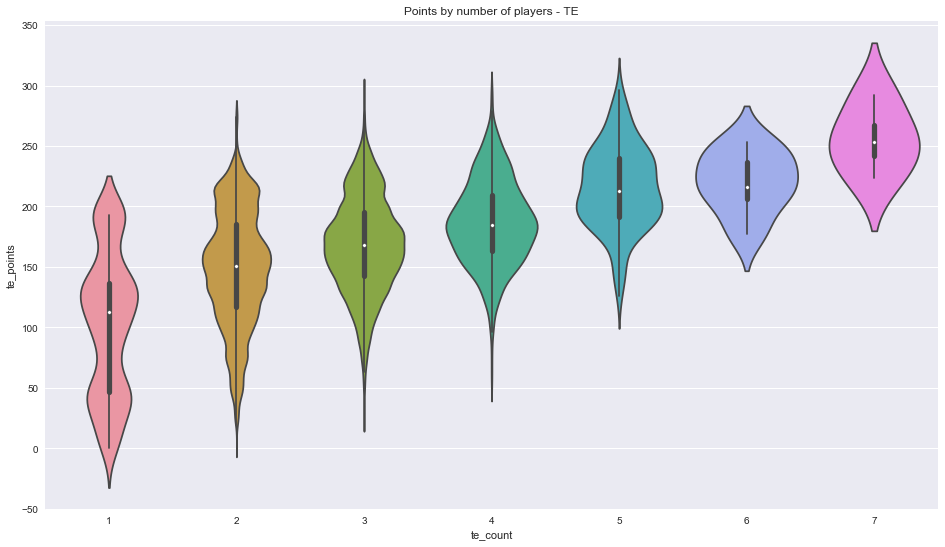

In [175]:
for position in POSITIONS:
    _pos_count = '{}_count'.format(position)
    _pos_points = '{}_points'.format(position)
    
    sns.violinplot(data=df_base, x=_pos_count, y=_pos_points)
    
    plt.title('Points by number of players - {0}'.format(position.upper()))
    plt.show()

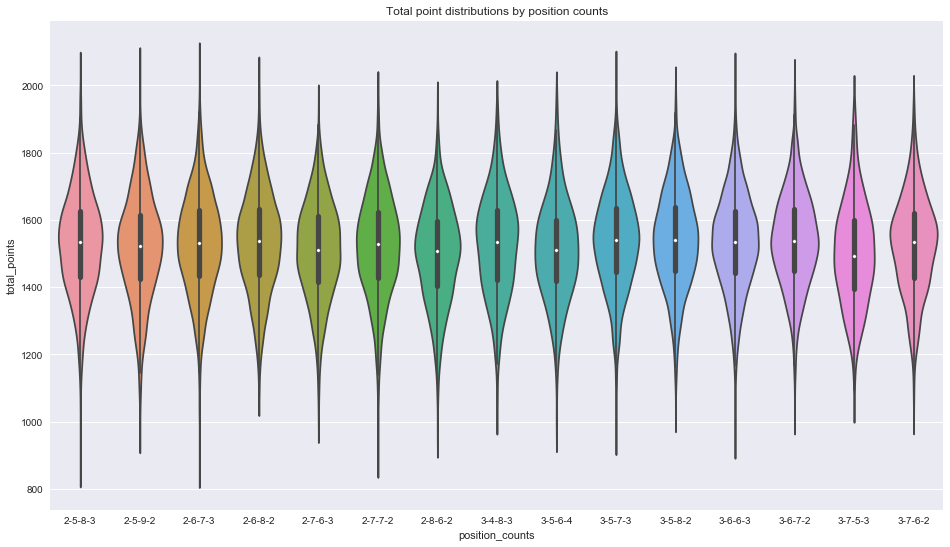

In [168]:
TOP_POS_COUNT = 15
position_counts = list(df_positions.head(TOP_POS_COUNT)['position_counts'])

sns.violinplot(data=df_base[df_base['position_counts'].isin(position_counts)],
               x='position_counts', y='total_points')

plt.title('Distribution of total points by position counts')
plt.show()

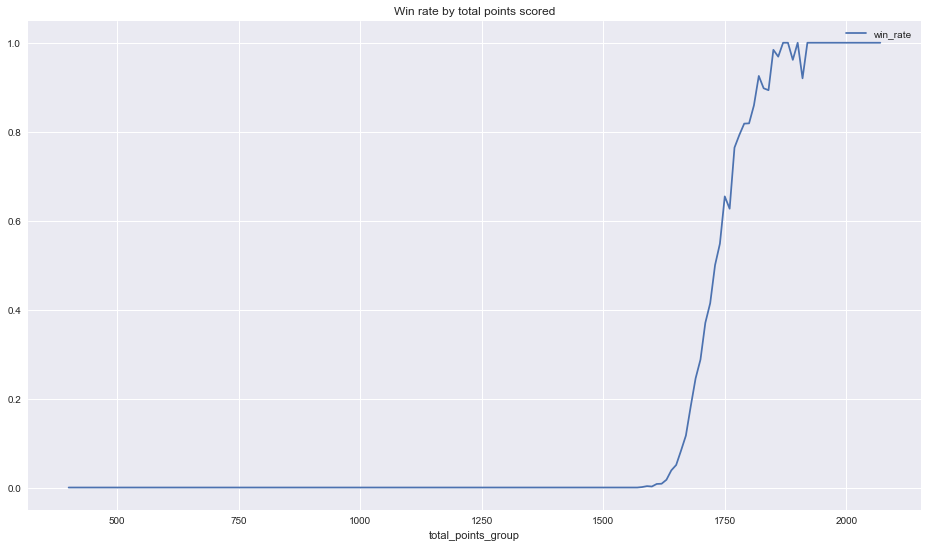

In [147]:
df_points.plot(x='total_points_group', y='win_rate')

plt.title('Win rate by total points scored')
plt.show()

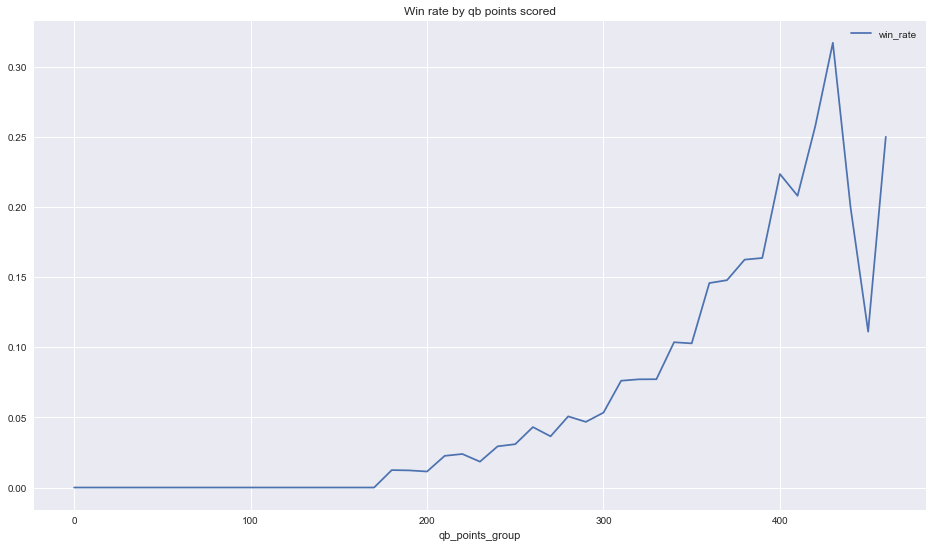

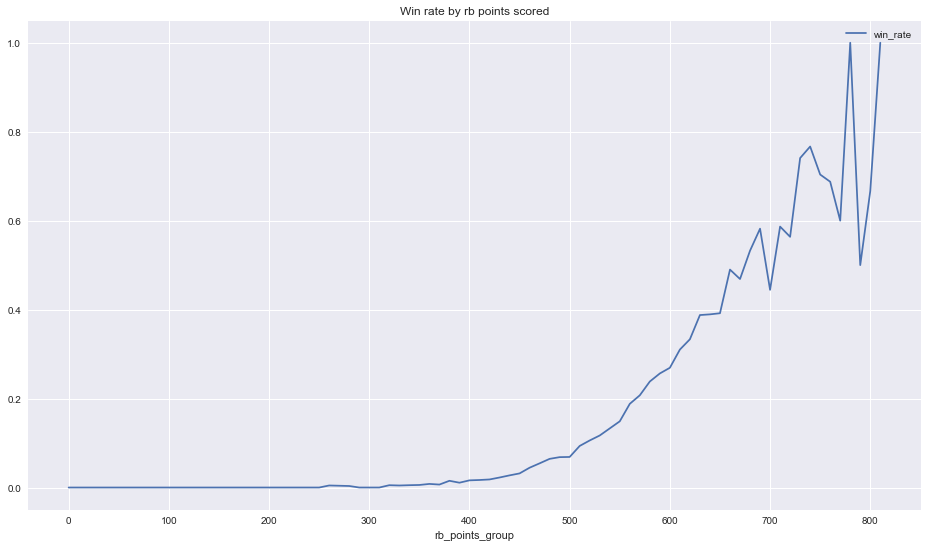

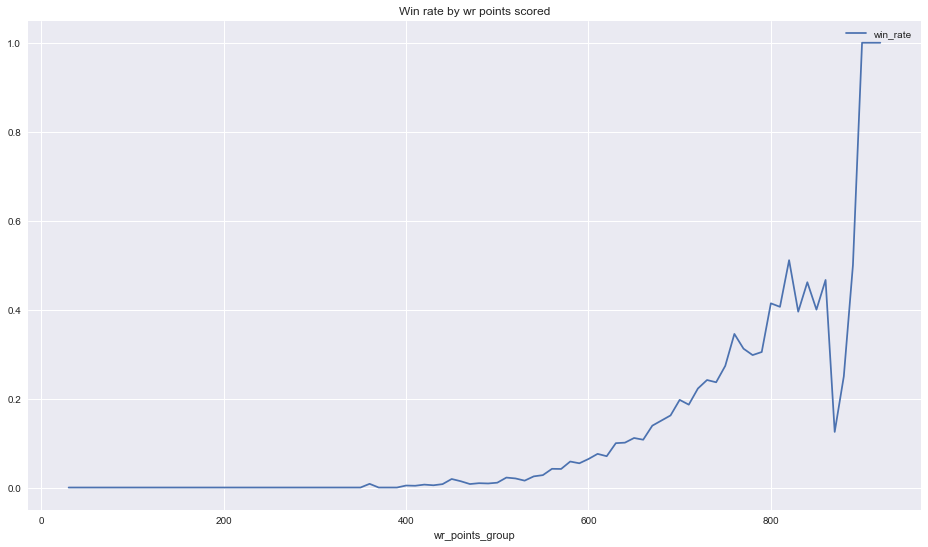

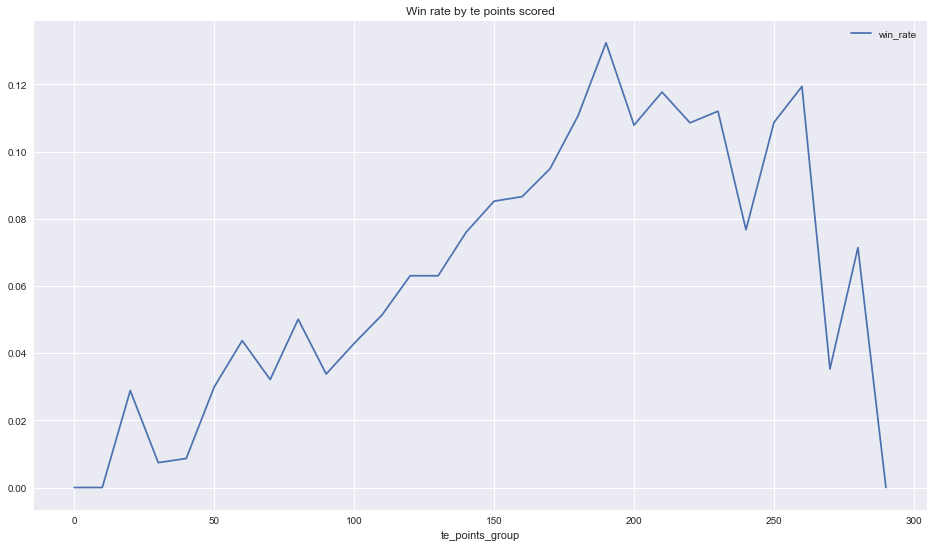

In [174]:
for position in POSITIONS:
    _pos_points_group = '{}_points_group'.format(position)

    _df = df_base.groupby([
        _pos_points_group
    ], as_index=False).agg({
        'draft_id': 'count',
        'win_flag': 'sum'
    }).rename(columns={
        'draft_id': 'teams',
        'win_flag': 'wins'
    })

    _df['win_rate'] = _df['wins'] / _df['teams']

    _df.plot(x=_pos_points_group, y='win_rate')

    plt.title('Win rate by {} points scored'.format(position))
    plt.show()

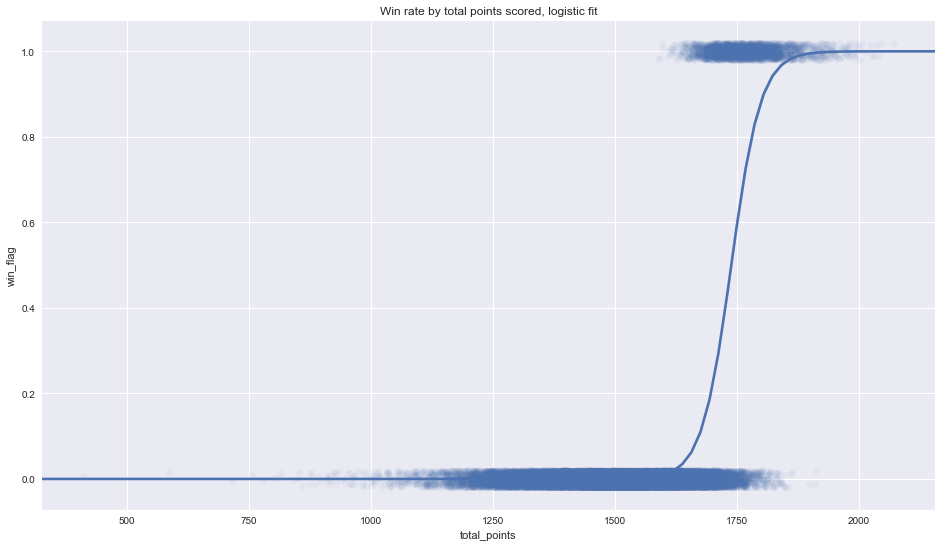

In [156]:
sns.regplot(data=df_base, x='total_points', y='win_flag', y_jitter=0.02,
            n_boot=500, logistic=True, scatter_kws={'alpha': 0.05})

plt.title('Win rate by total points scored, logistic fit')
plt.show()

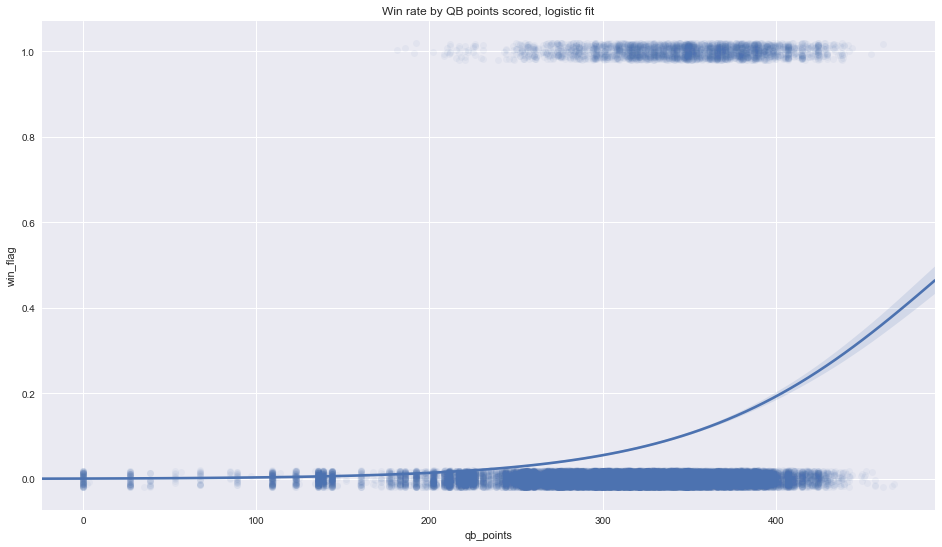

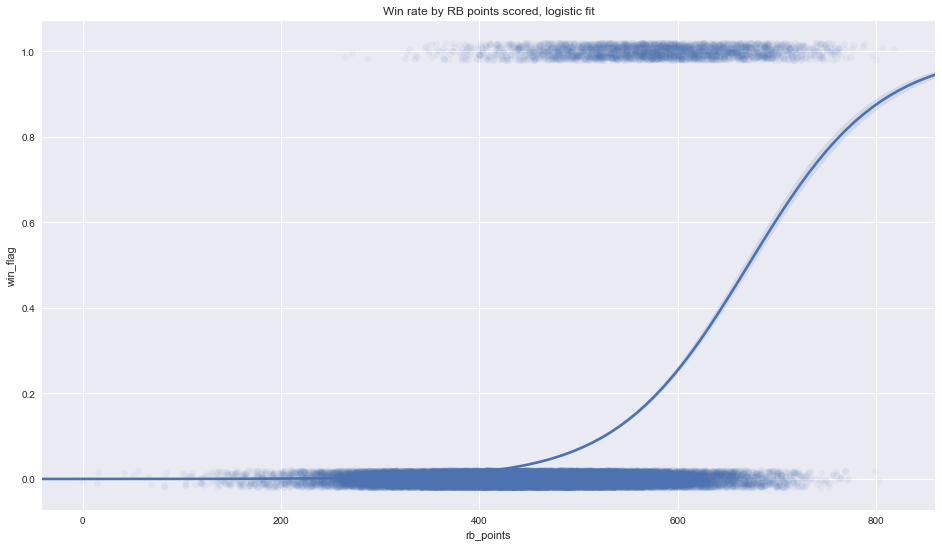

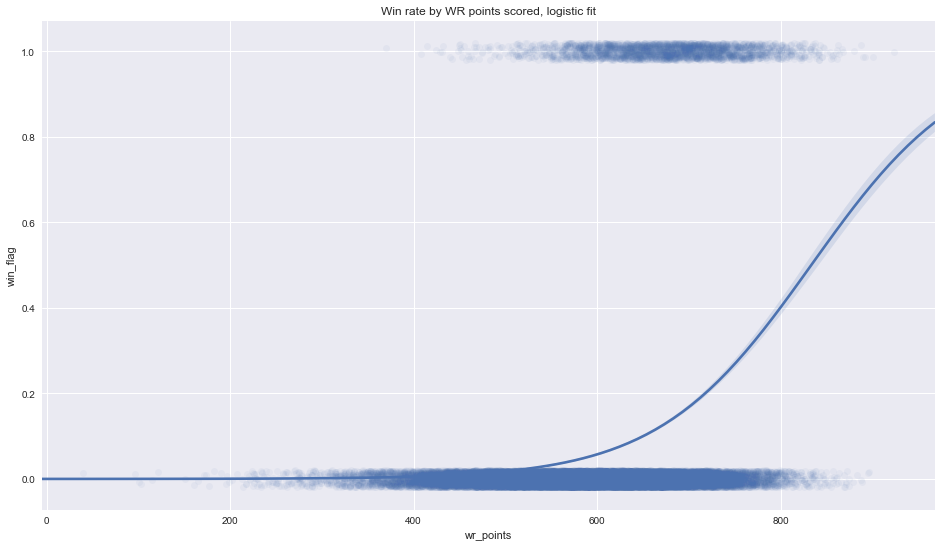

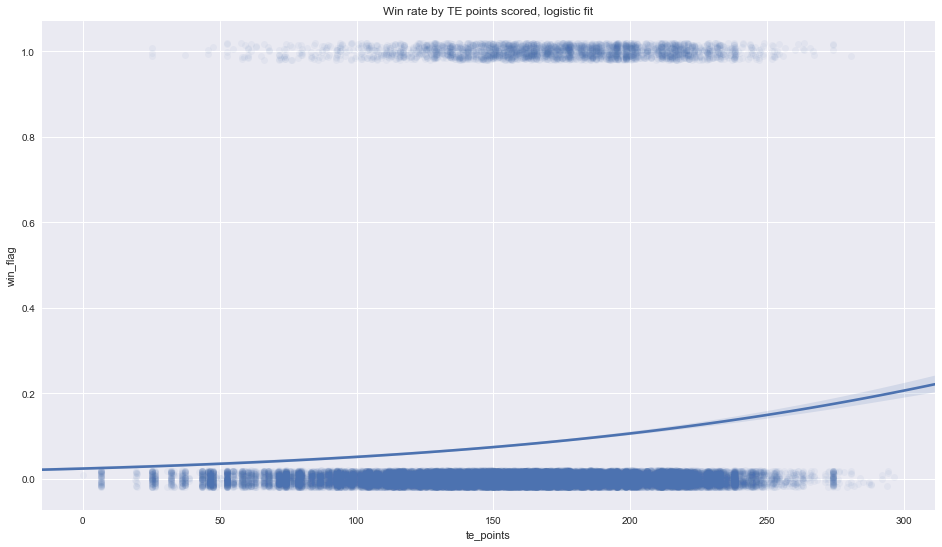

In [157]:
for position in POSITIONS:
    _pos_points = '{}_points'.format(position)
    
    sns.regplot(data=df_base, x=_pos_points, y='win_flag', y_jitter=0.02,
                n_boot=500, logistic=True, scatter_kws={'alpha': 0.05})
    
    plt.title('Win rate by {} points scored, logistic fit'.format(position.upper()))
    plt.show()

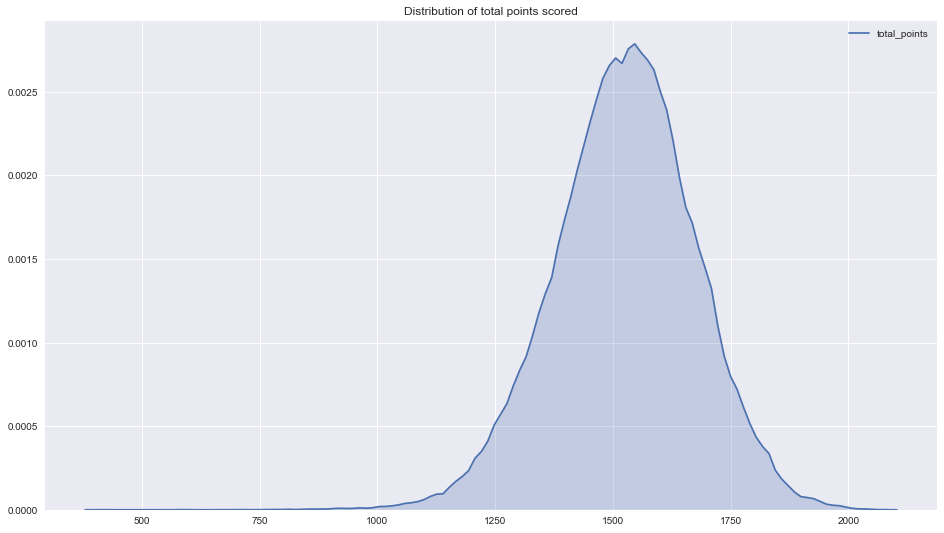

In [187]:
sns.kdeplot(data=df_base['total_points'], bw=10, shade=True)

plt.title('Distribution of total points scored')
plt.show()

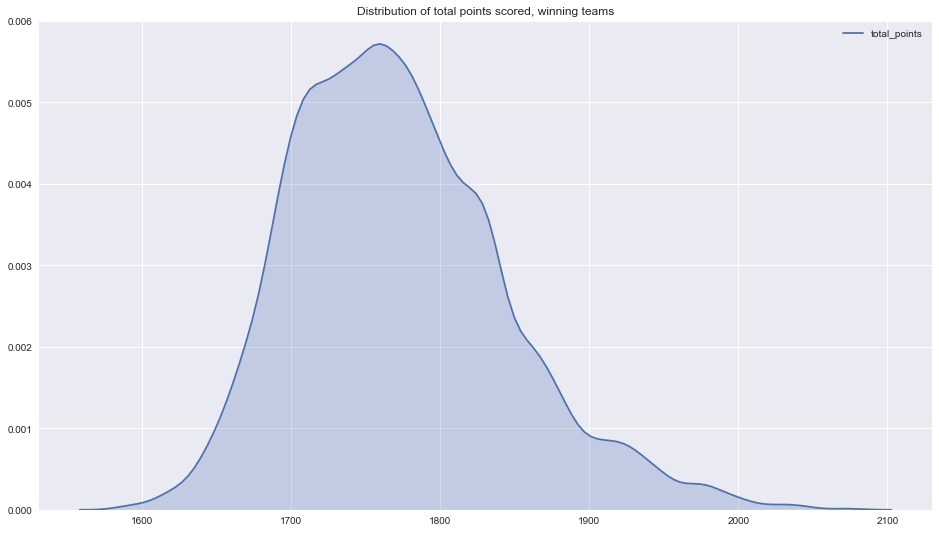

In [183]:
_df = df_base[df_base['win_flag'] == 1]

sns.kdeplot(data=_df['total_points'], bw=10, shade=True)

plt.title('Distribution of total points scored, winning teams')
plt.show()

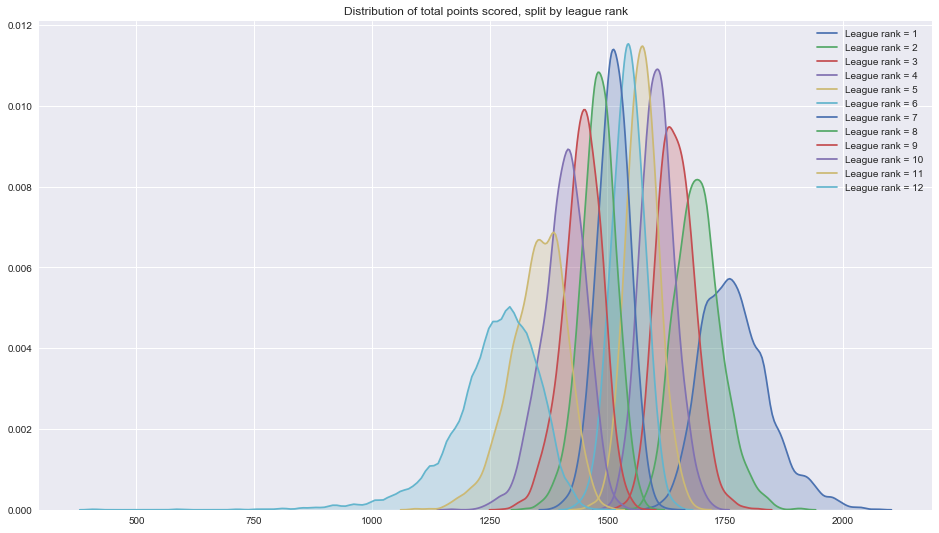

In [189]:
for league_rank in df_base['league_rank'].unique():
    _df = df_base[df_base['league_rank'] == league_rank]
    _label = 'League rank = {}'.format(league_rank)
    
    sns.kdeplot(data=_df['total_points'], bw=10, shade=True, label=_label)

plt.title('Distribution of total points scored, split by league rank')
plt.show()

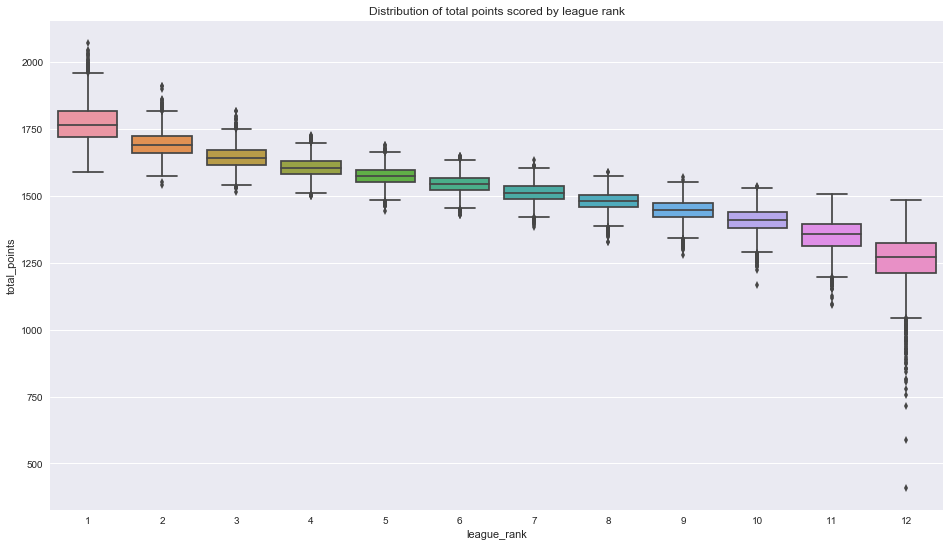

In [194]:
sns.boxplot(data=df_base, x='league_rank', y='total_points')

plt.title('Distribution of total points scored by league rank')
plt.show()

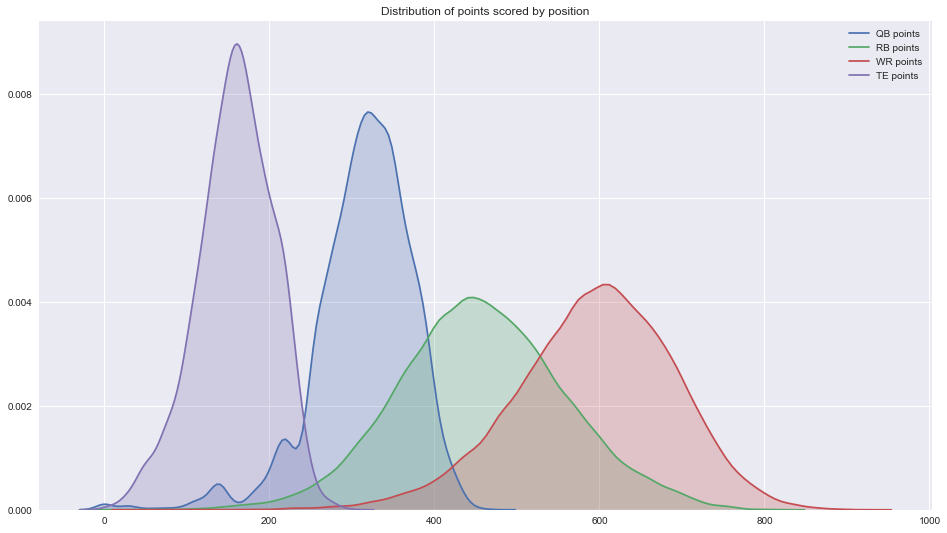

In [180]:
for position in POSITIONS:
    _pos_points = '{}_points'.format(position)
    _label = '{} points'.format(position.upper())

    sns.kdeplot(data=df_base[_pos_points], bw=10, shade=True, label=_label)
    
plt.title('Distribution of points scored by position')
plt.show()

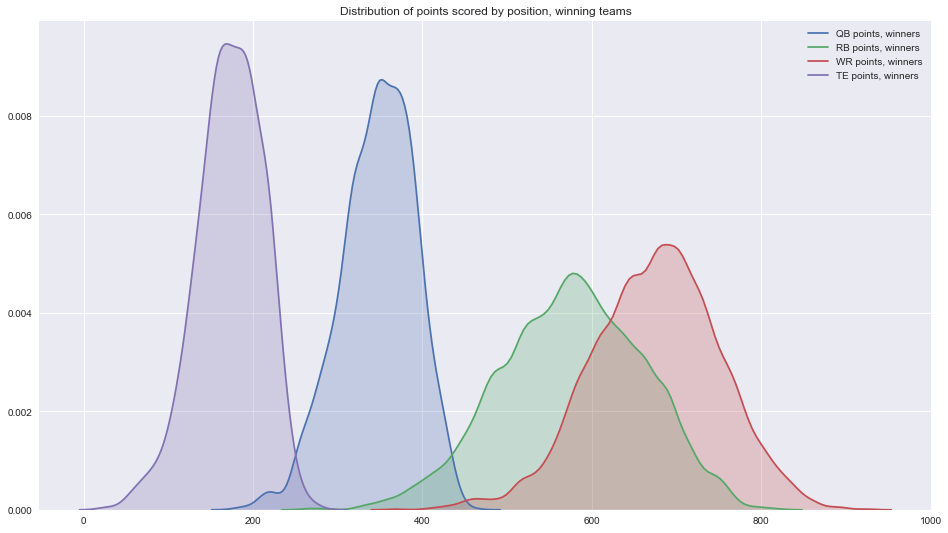

In [181]:
for position in POSITIONS:
    _pos_points = '{}_points'.format(position)
    _label = '{} points, winners'.format(position.upper())
    _df = df_base[df_base['win_flag'] == 1]

    sns.kdeplot(data=_df[_pos_points], bw=10, shade=True, label=_label)

plt.title('Distribution of points scored by position, winning teams')
plt.show()

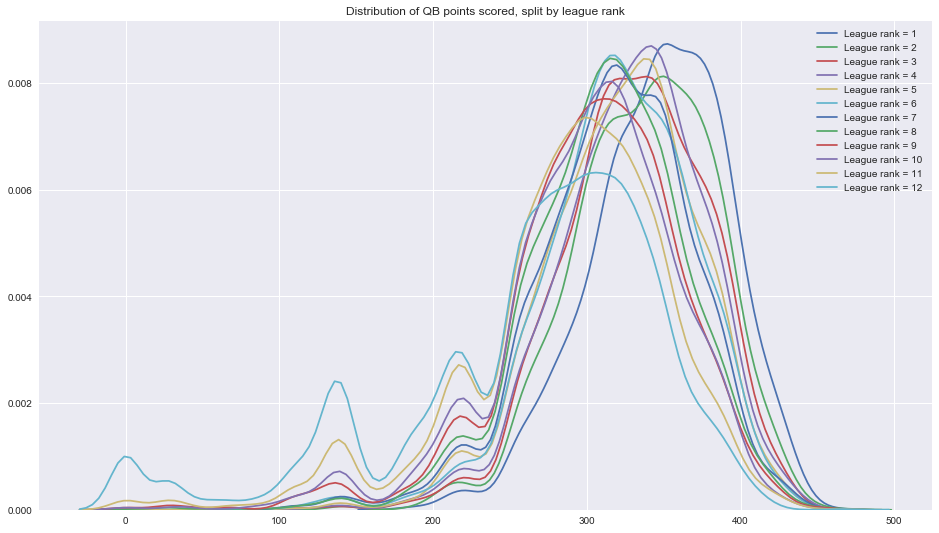

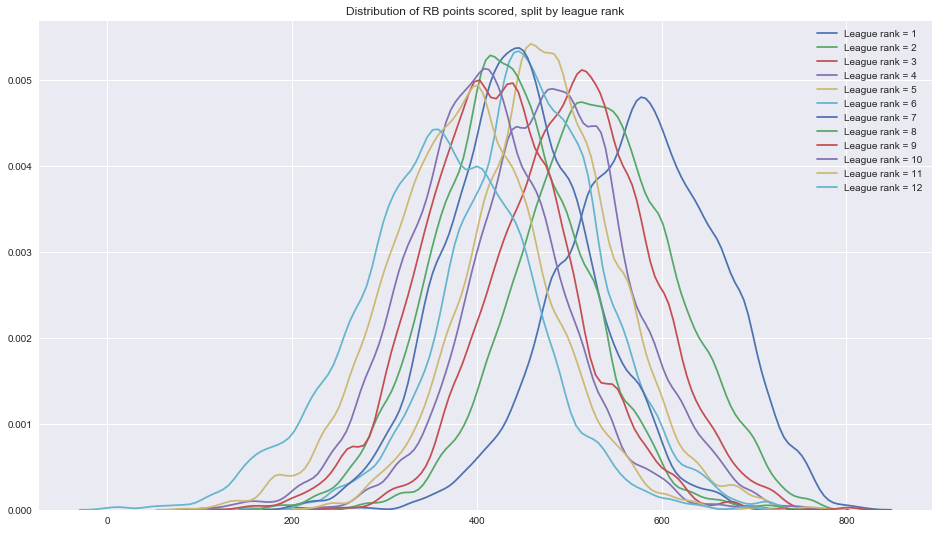

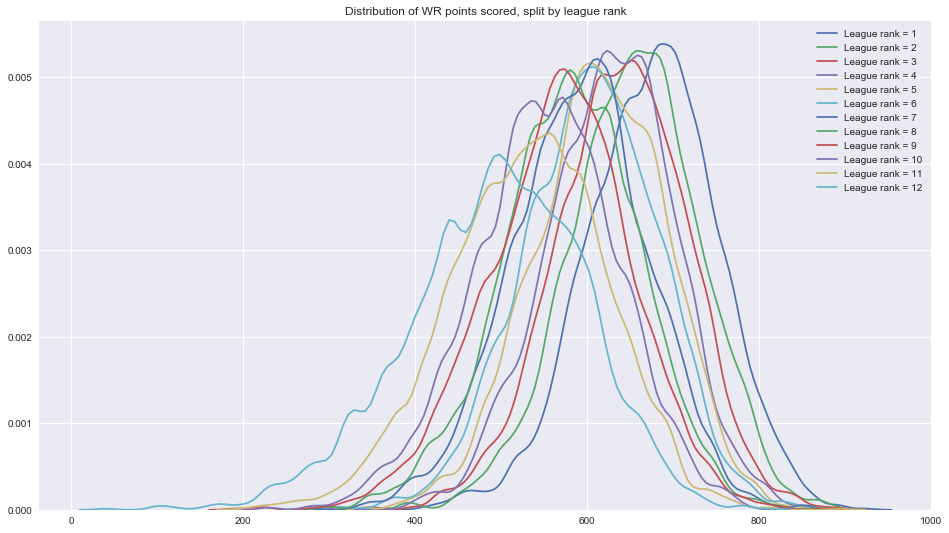

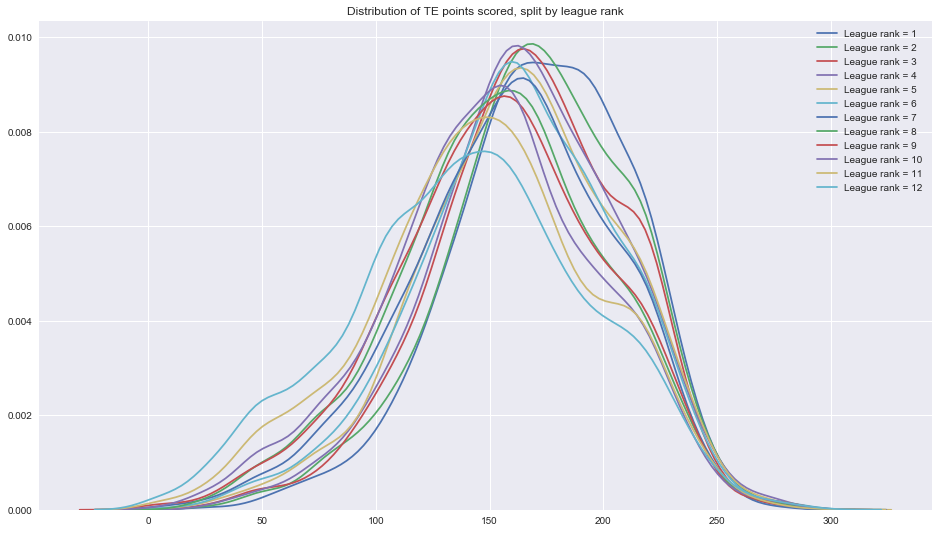

In [191]:
for position in POSITIONS:
    _pos_points = '{}_points'.format(position)
    
    for league_rank in df_base['league_rank'].unique():
        _df = df_base[df_base['league_rank'] == league_rank]
        _label = 'League rank = {}'.format(league_rank)

        sns.kdeplot(data=_df[_pos_points], bw=10, label=_label)

    plt.title('Distribution of {} points scored, split by league rank'.format(position.upper()))
    plt.show()

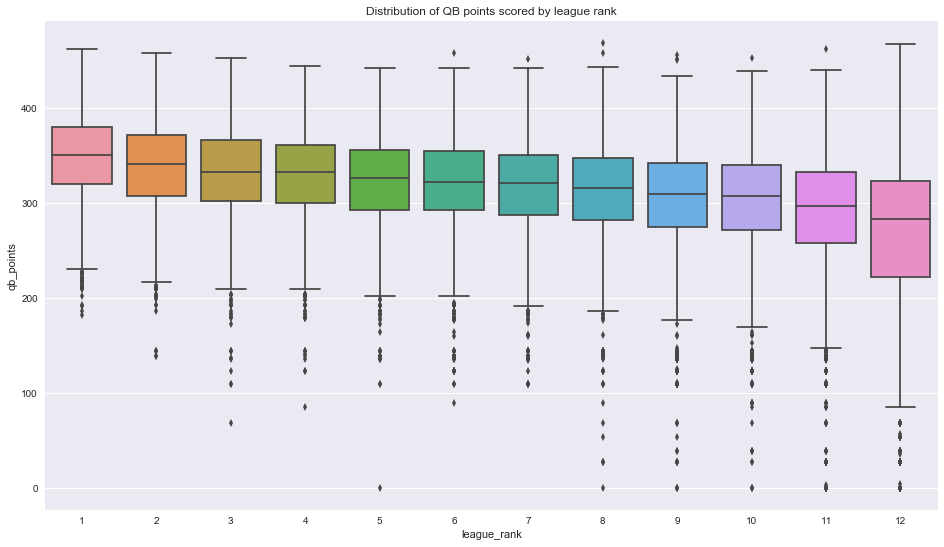

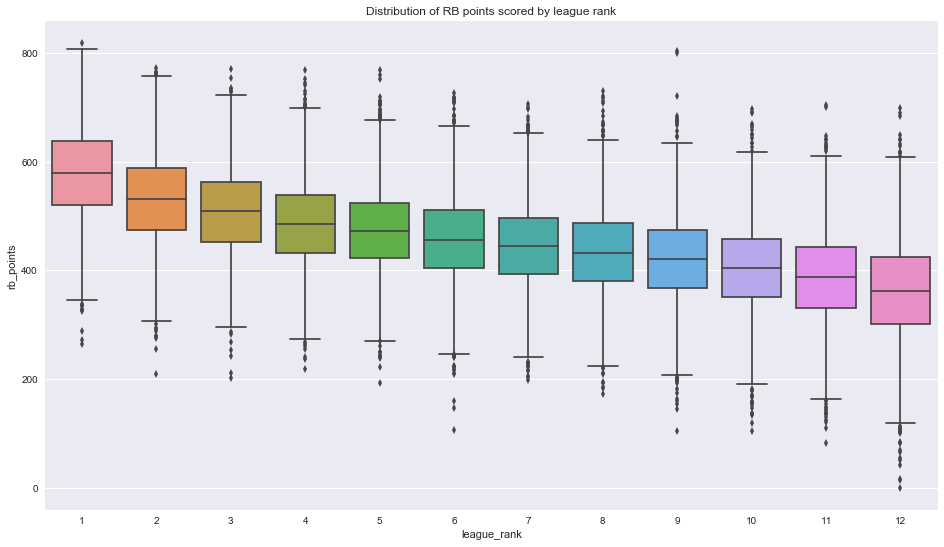

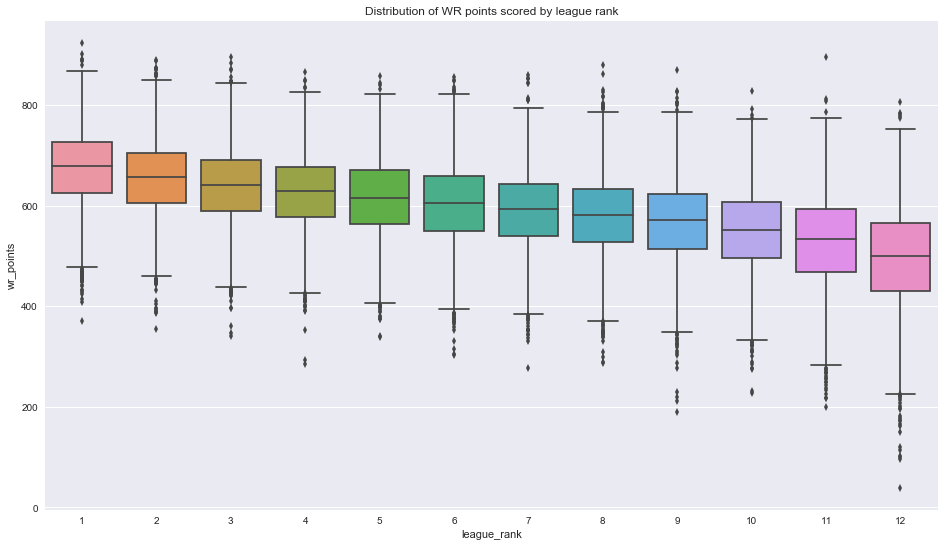

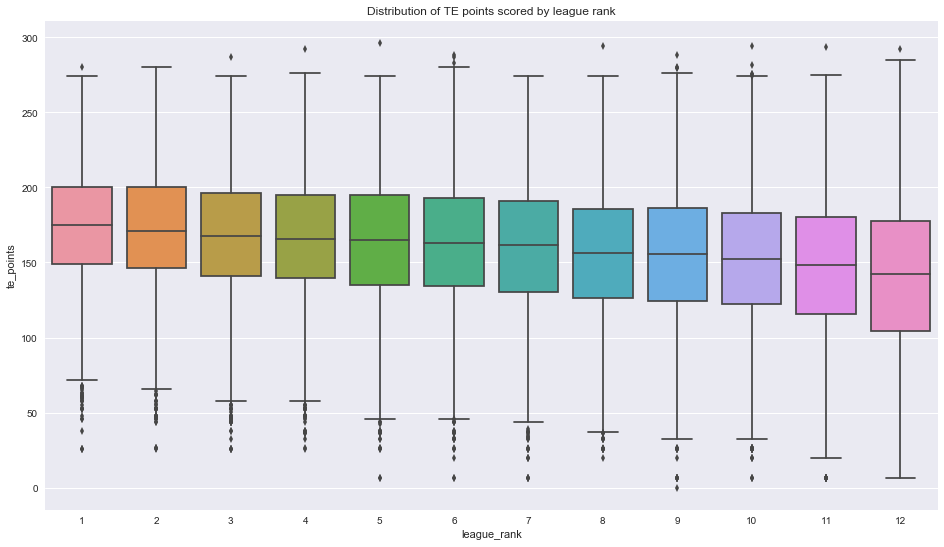

In [193]:
for position in POSITIONS:
    _pos_points = '{}_points'.format(position)
    
    sns.boxplot(data=df_base, x='league_rank', y=_pos_points)

    plt.title('Distribution of {} points scored by league rank'.format(position.upper()))
    plt.show()

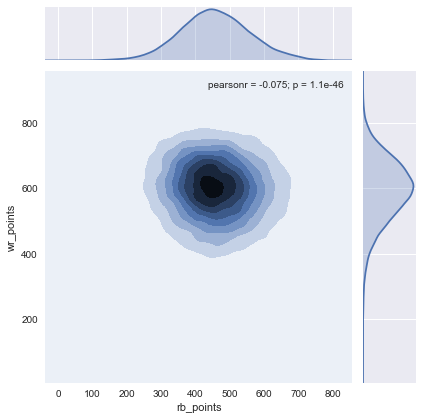

In [203]:
sns.jointplot(data=df_base, x='rb_points', y='wr_points', kind='kde')